In [1]:
# импорт всех необходимых библиотек
import gymnasium as gym
import matplotlib.pyplot as plt
import ale_py

### Загрузка среды

Начальное состояние: (210, 160, 3)
Информация о среде: {'lives': 5, 'episode_frame_number': 0, 'frame_number': 0}


A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


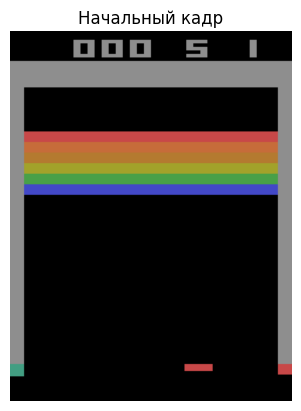

Действие: 1, Награда: 0.0, Завершено: False


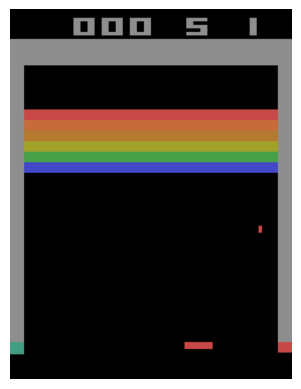

Действие: 3, Награда: 0.0, Завершено: False


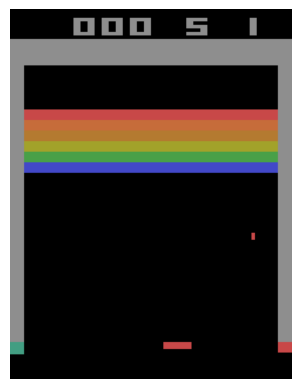

Действие: 2, Награда: 0.0, Завершено: False


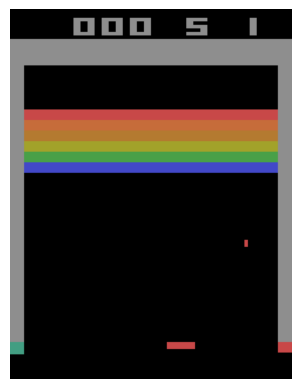

Действие: 0, Награда: 0.0, Завершено: False


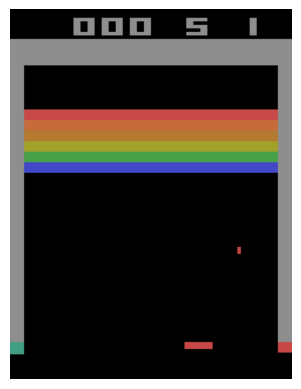

Действие: 0, Награда: 0.0, Завершено: False


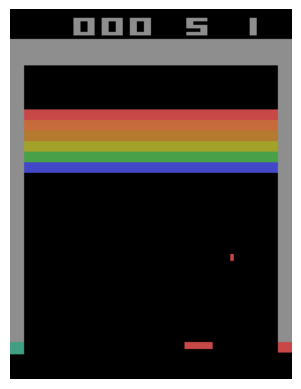

In [2]:
# Загрузка среды
env = gym.make('ALE/Breakout-v5', frameskip=4, repeat_action_probability=0.25, render_mode='rgb_array')
state, info = env.reset()

# Проверка начального состояния
print("Начальное состояние:", state.shape)
print("Информация о среде:", info)

# Визуализация начального кадра
plt.imshow(env.render())
plt.title("Начальный кадр")
plt.axis("off")
plt.show()

# Тестирование выполнения нескольких действий
for _ in range(5):
    action = env.action_space.sample()  # Случайное действие
    state, reward, terminated, truncated, info = env.step(action)
    print(f"Действие: {action}, Награда: {reward}, Завершено: {terminated or truncated}")
    plt.imshow(env.render())
    plt.axis("off")
    plt.show()

env.close()
